In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from circleguard import KeylessCircleguard, ReplayDir
from slider import Library

from utils.replay_processing import get_embeddings, get_beatmap_context

plt.style.use("ggplot")

print(tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

True
Num GPUs Available:  1


In [15]:
EMBEDDING_DIM = 16
JUDGMENT_DIM = 4
BEATMAP_CONTEXT_DIM = 8
NOTES_PER_EXAMPLE = 64

INDEX_PATH = "../data/indices/base_index.csv"
BEATMAP_PATH = "../data/beatmaps"
REPLAY_PATH = "../data/replays/osr"
DB_PATH = "../data/replays/osr/.circleguard.db"
SLIDER_PATH = "../data/beatmaps"

CONTEXT_LABELS = [
    "ar",
    "circle_radius",
    "hp",
    "hitwindow_300",
    "hitwindow_100",
    "hitwindow_50",
    "hd",
    "dt",
]

EMBEDDING_LABELS = [
    "x_pos",
    "y_pos",
    "in_x_offset",
    "in_y_offset",
    "in_dist",
    "in_timedelta",
    "out_x_offset",
    "out_y_offset",
    "out_dist",
    "out_timedelta",
    "angle",
    "is_slider",
    "slider_duration",
    "slider_length",
    "slider_num_ticks",
    "slider_num_beats"
]

NULL_LABELS = [
    "p_300_null",
    "p_100_null",
    "p_50_null",
    "p_miss_null"
]

PROB_LABELS = [
    "p_300",
    "p_100",
    "p_50",
    "p_miss"
]

In [5]:
index_df = pd.read_csv(INDEX_PATH, low_memory = False)
beatmap_library = Library(BEATMAP_PATH)

print(f"Num. replays in index: {len(index_df)}")
print(f"Num. of beatmaps in library: {len(beatmap_library.ids)}")
index_df.head()

Num. replays in index: 381570
Num. of beatmaps in library: 55079


,Unnamed: 0,replayHash,beatmapHash,summary,date,playerName,modsReadable,mods,performance-IsFail,performance-Accuracy,...,beatmap-Circles,beatmap-Sliders,beatmap-Spinners,beatmapPlay-BPMMin,beatmapPlay-BPMMax,beatmapPlay-HP,beatmapPlay-OD,beatmapPlay-AR,beatmapPlay-CS,osrReplayUrl
0,0,857623324645f59599fc4e9c1c7e1130,db4cdde15984869de346686ceb6bc1a5,[7.44 ⭐] My Angel Shori | Imperial Circus Dead...,2022-11-11T08:03:56.656728,My Angel Shori,NaN,0,False,0.954368,...,1438,442,1,134.0,235.0,5.0,9.200000,9.700000,4.5,https://dl.issou.best/ordr/replays/cfc43370ca0...
1,1,b1675645282756f18e0c3f142f290d94,04129d1b26d6bf3f35cb00a04f4a8c88,[6.55 ⭐] AlexTheProtoTTV | katagiri - Buta Mus...,2022-11-11T04:37:52.235160,AlexTheProtoTTV,NaN,0,False,0.857687,...,832,392,1,210.0,210.0,4.5,9.200000,9.800000,3.8,https://dl.issou.best/ordr/replays/e35f6f3e3b1...
2,2,6170131dcd9ad32d4c0287422b256423,8e3e4e77e6498a994bfa7505e735155d,[6.37 ⭐] Asio_ | Qrispy Joybox feat. mao - Col...,2022-11-11T08:01:02.823288,Asio_,HDDT,72,False,0.916667,...,189,118,1,228.0,228.0,5.2,10.083333,10.333333,3.8,https://dl.issou.best/ordr/replays/f214715d45d...
3,3,d3fc501dadc1fabd60f847432cc3de84,27f9c5f8496bfdab8623e3be6cf73f25,[6.3 ⭐] sotarks fan123 | DragonForce - Valley ...,2022-11-11T07:46:29.042768,sotarks fan123,NaN,0,True,0.948815,...,1486,660,2,71.0,200.0,6.0,8.500000,9.200000,4.0,https://dl.issou.best/ordr/replays/cf3f6778f86...
4,4,8e62a939e4c97fe22cbd90e90d338a53,1e8f966c7a8f992cb2f3f5bab7d55925,[6.34 ⭐] XxSzymenxx | DragonForce - Through th...,2022-03-11T10:40:06.741672,XxSzymenxx,NaN,0,True,0.731128,...,1534,587,5,170.0,200.0,6.2,9.000000,9.500000,4.0,https://dl.issou.best/ordr/replays/b90ed42a04b...


In [16]:
_hit_300 = tf.constant([[1.0, 0.0, 0.0, 0.0]])

def _get_embedding_sequence(embeddings, replay_len, note_idx):
    
    embs = None
    if replay_len - note_idx - NOTES_PER_EXAMPLE >= 0:
        embs = embeddings[ replay_len - note_idx - NOTES_PER_EXAMPLE : replay_len - note_idx , :]
    else:
        embs = embeddings[ 0 : replay_len - note_idx , :]  
        
    judgs = tf.tile(_hit_300, [len(embs) - 1, 1])
    judgs = tf.concat([judgs, tf.zeros([1, JUDGMENT_DIM])], axis = 0)
    
    return tf.concat([embs, judgs], axis = 1)


def _replay_to_np_features(replay, beatmap_library):
    
    beatmap_context = get_beatmap_context(replay, beatmap_library)
    beatmap_context = np.reshape(beatmap_context, (BEATMAP_CONTEXT_DIM,))
    
    embs = get_embeddings(replay, beatmap_library)
    replay_len = len(embs)
    
    if replay_len <= NOTES_PER_EXAMPLE:
        return None
    
    res = np.zeros((replay_len, NOTES_PER_EXAMPLE, EMBEDDING_DIM + JUDGMENT_DIM + BEATMAP_CONTEXT_DIM))
    
    for note_idx in range(replay_len):
         
        embedding_sequence = _get_embedding_sequence(embs, replay_len, note_idx)
        context_sequence = np.tile(beatmap_context, [len(embedding_sequence), 1])
        
        sequence = np.concatenate([embedding_sequence, context_sequence], axis = 1)        
        padding = np.zeros(shape = [NOTES_PER_EXAMPLE - len(embedding_sequence), EMBEDDING_DIM + BEATMAP_CONTEXT_DIM + JUDGMENT_DIM])
    
        res[note_idx, :, :] =  np.concatenate([padding, sequence], axis = 0)
        
    return res


def _np_embs_to_notes_df(np_features, model):
    
    if np_features is None:
        return None
    
    probs = model.predict_on_batch(np_features)
    
    res_df = pd.DataFrame(
        np.concatenate(
            (np_features[:, -1, :], probs), 
            axis = 1
        ), columns = EMBEDDING_LABELS + NULL_LABELS + CONTEXT_LABELS + PROB_LABELS
    )[::-1]
    
    return res_df.reset_index(drop = True)


    
def get_notes_df( replay, beatmap_library, model ):
    
    np_features = _replay_to_np_features( replay, beatmap_library )
    return _np_embs_to_notes_df( np_features, model )


def plot_difficulty(notes_df, replay_name = "Unnamed Beatmap", replay_mod_str = "?"):
    
    fig, ax = plt.subplots(figsize = (18, 5))

    ax.set_title(f"Estimated Hit Probabilities: {replay_name} ({replay_mod_str})")
    
    ax.set_ylabel("Probability")
    ax.set_xlabel("Combo")
    
    ax.plot(notes_df["p_300"], color = "blue", label = "300")
    ax.plot(notes_df["p_100"], color = "green", label = "100")
    ax.plot(notes_df["p_50"], color = "purple", label = "50")
    ax.plot(notes_df["p_miss"], color = "red", label = "Miss")
    
    ax.legend()



# def plot_n_hardest(notes_df, n, replay_name = "Unnamed Beatmap", replay_mod_str = "?"):
    
#     fig, ax = plt.subplots(figsize = (8, 8))
    
    
#     tmp_df = notes_df.sort_values(by = "p_miss", ascending = False)[:n]
#     tmp_df = tmp_df.reset_index(drop = True)
    
#     ax.plot(tmp_df["p_miss"], color = "red", label = "P(Miss)")
#     print(f"Negative Log-Likelihood of FC: {sum(tmp_df['p_miss'].apply(lambda p: -np.log(1-p)))}")


#     tmp_df = notes_df
#     tmp_df["p_300_tmp"] = tmp_df.apply(lambda row: row["p_300"] / (row["p_300"] + row["p_100"] + row["p_50"]), axis = 1)
#     tmp_df = tmp_df.sort_values(by = "p_300_tmp", ascending = True)[:n]
#     tmp_df = tmp_df.reset_index(drop = True)
    
#     ax.plot(tmp_df["p_300_tmp"], color = "blue", label = "P(300 | Hit)")
    
    
#     ax.set_title(f"Hardest Notes: {replay_name} ({replay_mod_str})")
#     ax.set_ylabel("Probability")
#     ax.set_xlabel("Nth Hardest")

#     ax.set_ylim(0, 1.1)
    
#     ax.legend()
    
    
    
def compute_likelihoods(notes_df):
    
    neg_loglik_SS = sum( notes_df["p_300"].apply(lambda p: -np.log(p)) )
    neg_loglik_S = sum( notes_df.apply(lambda row: -np.log(row["p_300"] + row["p_100"]), axis = 1) )
    neg_loglik_FC = sum( notes_df["p_miss"].apply(lambda p: -np.log(1 - p)) )
    
    return [neg_loglik_SS, neg_loglik_S, neg_loglik_FC]

In [7]:
NUM_REPLAYS = 1000
res = []

cg = KeylessCircleguard( 
    db_path = DB_PATH,
    slider_dir = SLIDER_PATH,
    cache = True
)

replay_dir = ReplayDir(REPLAY_PATH)
cg.load_info(replay_dir)
replay_dir.replays = replay_dir.replays[:NUM_REPLAYS]
cg.load(replay_dir)

In [8]:
MODEL_PATH = "../models/seq2seq/seq2seq_final.keras"
model = tf.keras.models.load_model(MODEL_PATH)

In [17]:
res = []

for idx, replay in enumerate(replay_dir):
    
    n_df = get_notes_df(replay, beatmap_library, model)
    if n_df is None:
        continue
    
    beatmap = replay.beatmap(beatmap_library)
    beatmap_name =  beatmap.display_name
    mod_str = str(replay.mods)
    stars = 0
    try:
        stars = beatmap.stars()
    except:
        continue
    
    tmp_df = n_df.sort_values(by = "p_miss", ascending = False)[:256]
    tmp_df = tmp_df.reset_index(drop = True)
    
    neg_loglik_hit = sum(tmp_df['p_miss'].apply(lambda p: -np.log(1-p)))
    
    tmp_df = n_df
    tmp_df["p_300_tmp"] = tmp_df.apply(lambda row: row["p_300"] / (row["p_300"] + row["p_100"] + row["p_50"]), axis = 1)
    tmp_df = tmp_df.sort_values(by = "p_300_tmp", ascending = True)[:256]
    tmp_df = tmp_df.reset_index(drop = True)
    
    neg_loglik_acc = sum(tmp_df['p_300_tmp'].apply(lambda p: -np.log(p)))

    res.append([idx, beatmap_name, mod_str, stars, neg_loglik_hit, neg_loglik_acc])

In [18]:
pd.DataFrame(res, columns = ["replay_idx", "beatmap_name", "mod_str", "nm_stars", "neg_loglik_FC", "neg_loglik_acc"]).to_csv("likelihoods_top_256.csv", index = False)

In [19]:
def plot_difficulty_by_idx(replay_idx, beatmap_library, model):
    
    replay = replay_dir[replay_idx]
    
    n_df = get_notes_df(replay, beatmap_library, model)
    beatmap_name =  replay.beatmap(beatmap_library).display_name
    mod_str = str(replay.mods)

    plot_difficulty(n_df, beatmap_name, mod_str)
    

def plot_n_hardest_by_idx(replay_idx, n, beatmap_library, model):
    
    replay = replay_dir[replay_idx]
    
    n_df = get_notes_df(replay, beatmap_library, model)
    beatmap_name =  replay.beatmap(beatmap_library).display_name
    mod_str = str(replay.mods)

    plot_n_hardest(n_df, n, beatmap_name, mod_str)

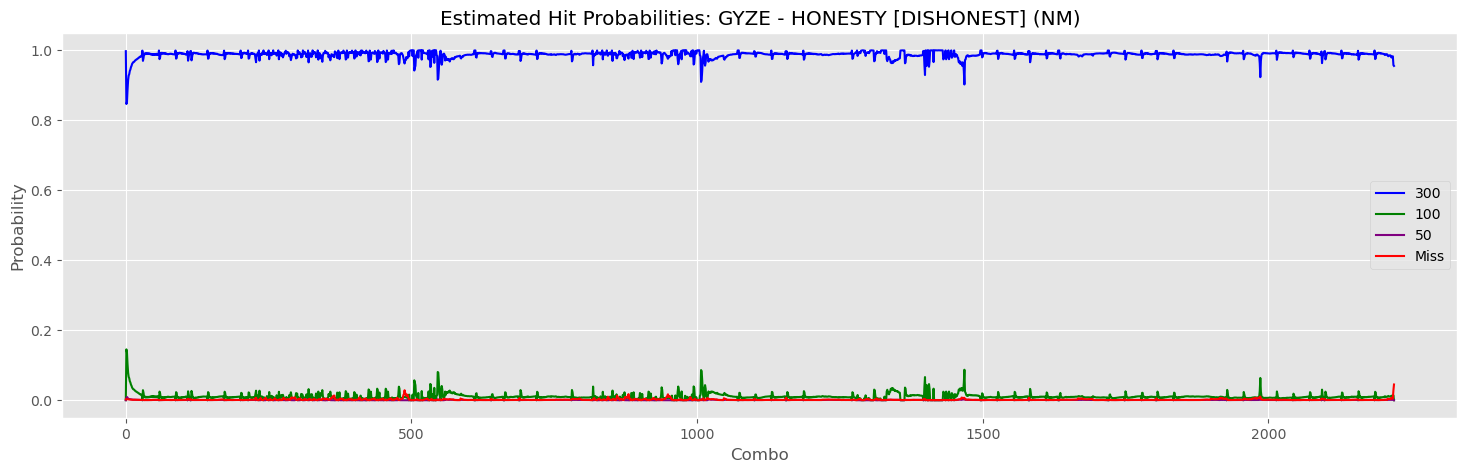

In [20]:
plot_difficulty_by_idx(418, beatmap_library, model)

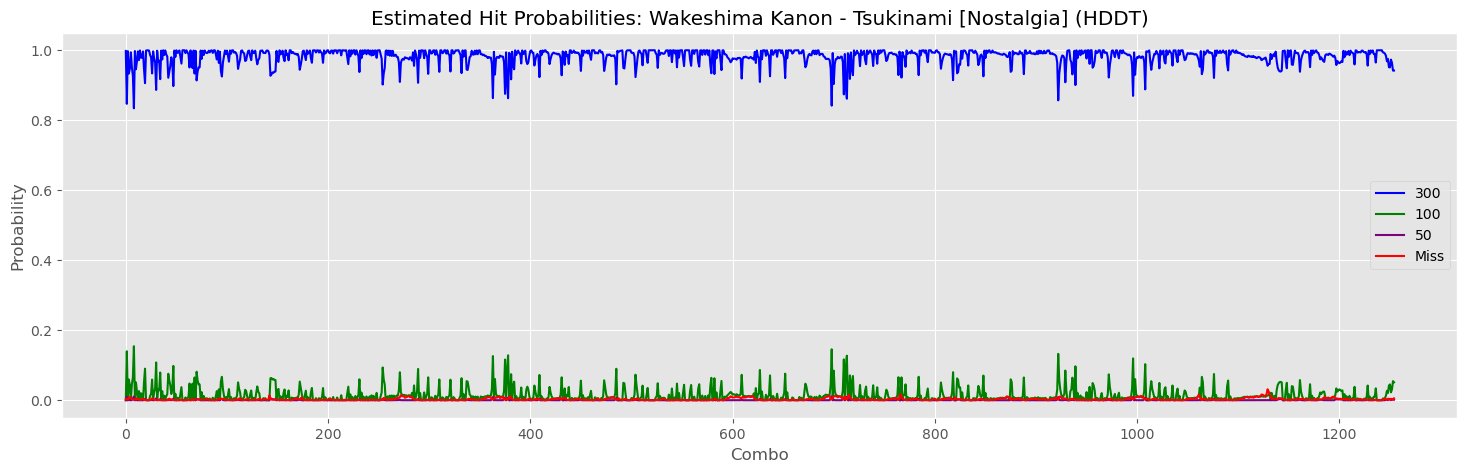

In [21]:
plot_difficulty_by_idx(581, beatmap_library, model)

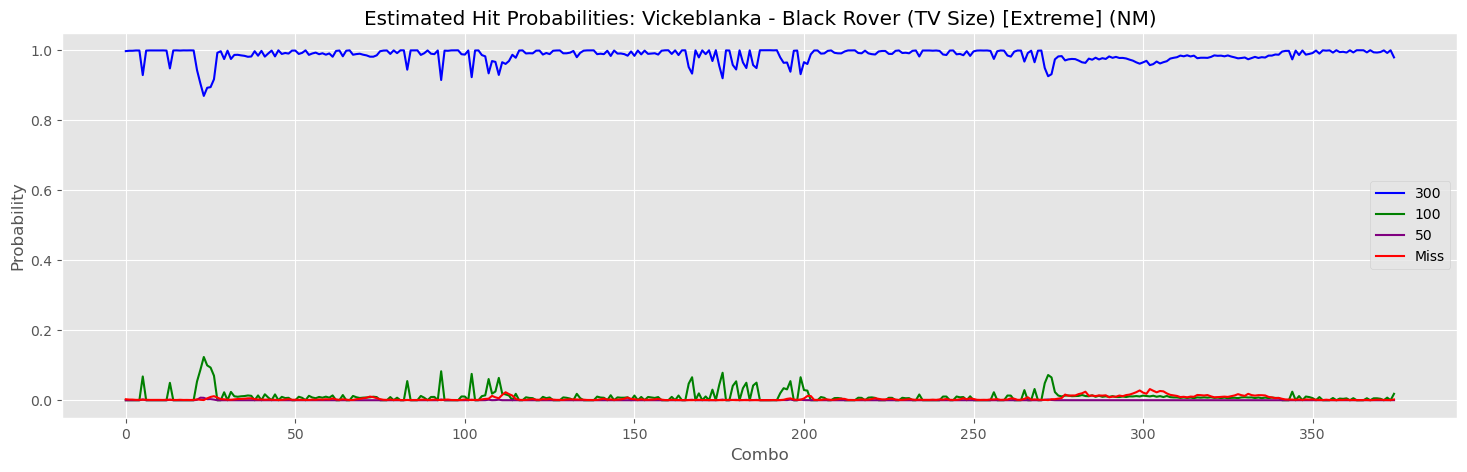

In [22]:
plot_difficulty_by_idx(810, beatmap_library, model)

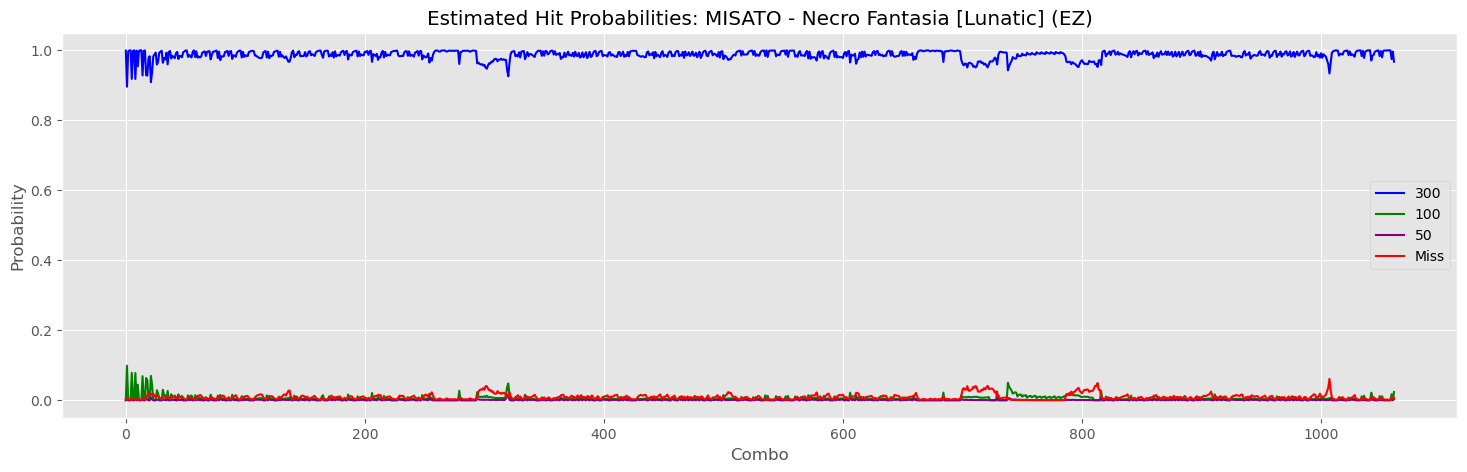

In [23]:
plot_difficulty_by_idx(658, beatmap_library, model)

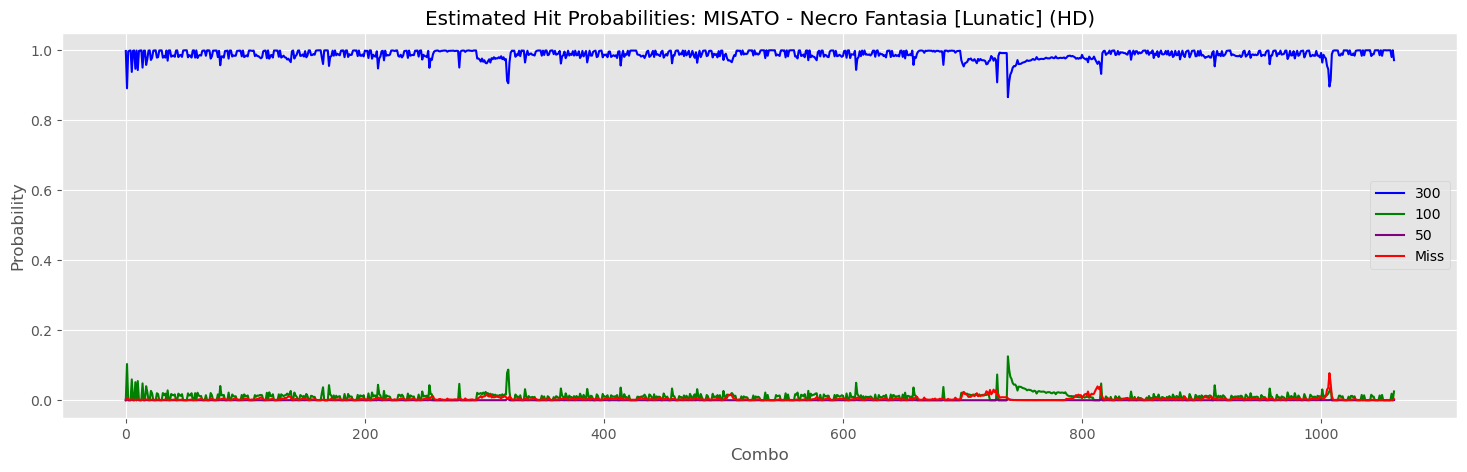

In [24]:
plot_difficulty_by_idx(590, beatmap_library, model)

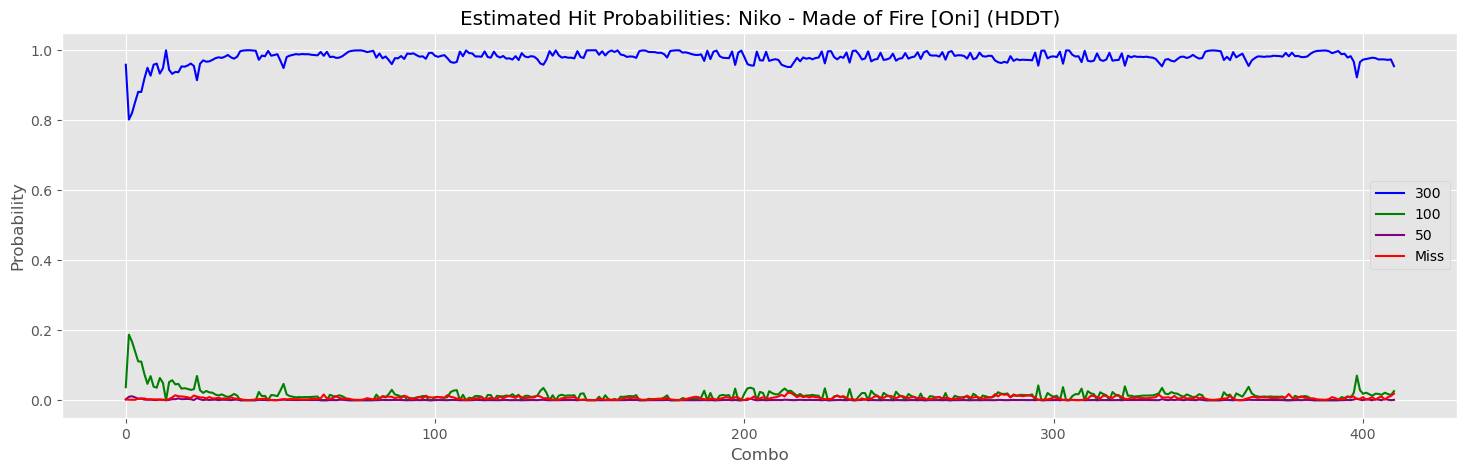

In [25]:
plot_difficulty_by_idx(793, beatmap_library, model)

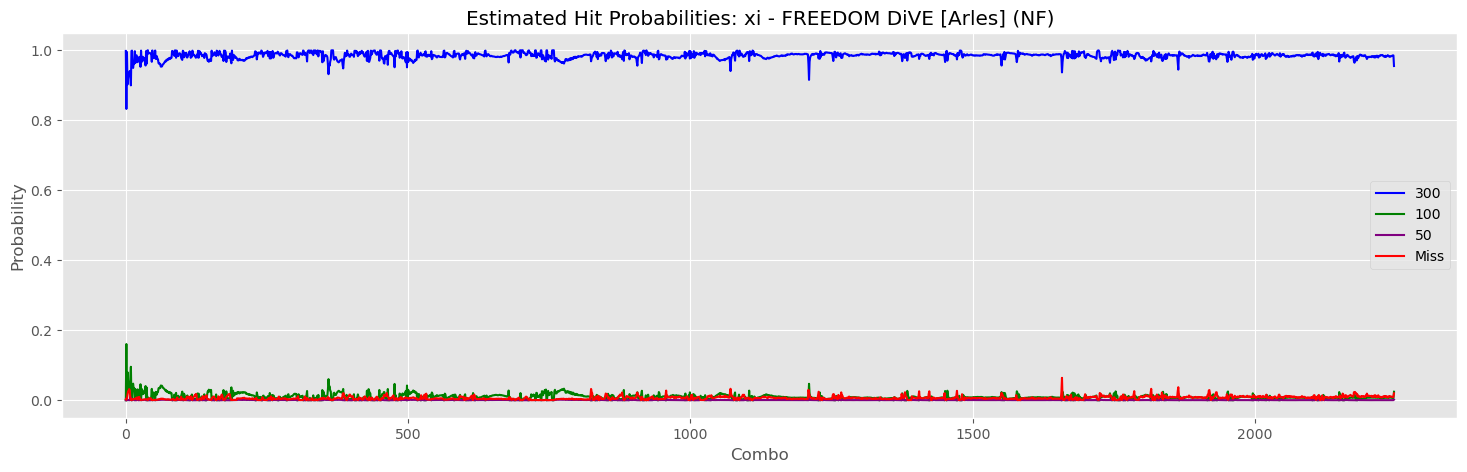

In [26]:
plot_difficulty_by_idx(913, beatmap_library, model)

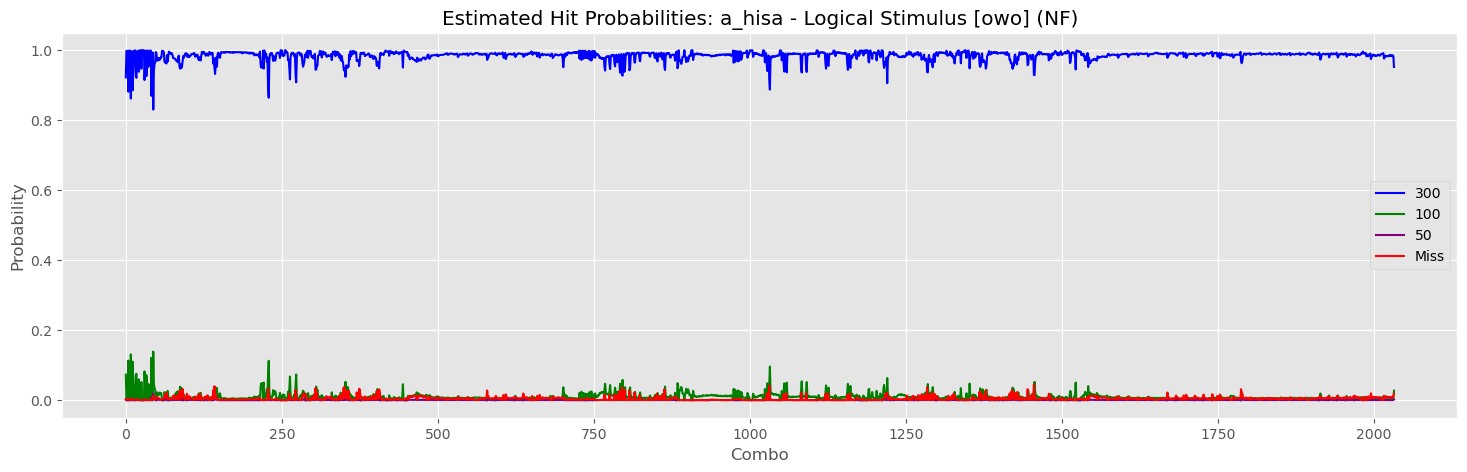

In [27]:
plot_difficulty_by_idx(889, beatmap_library, model)

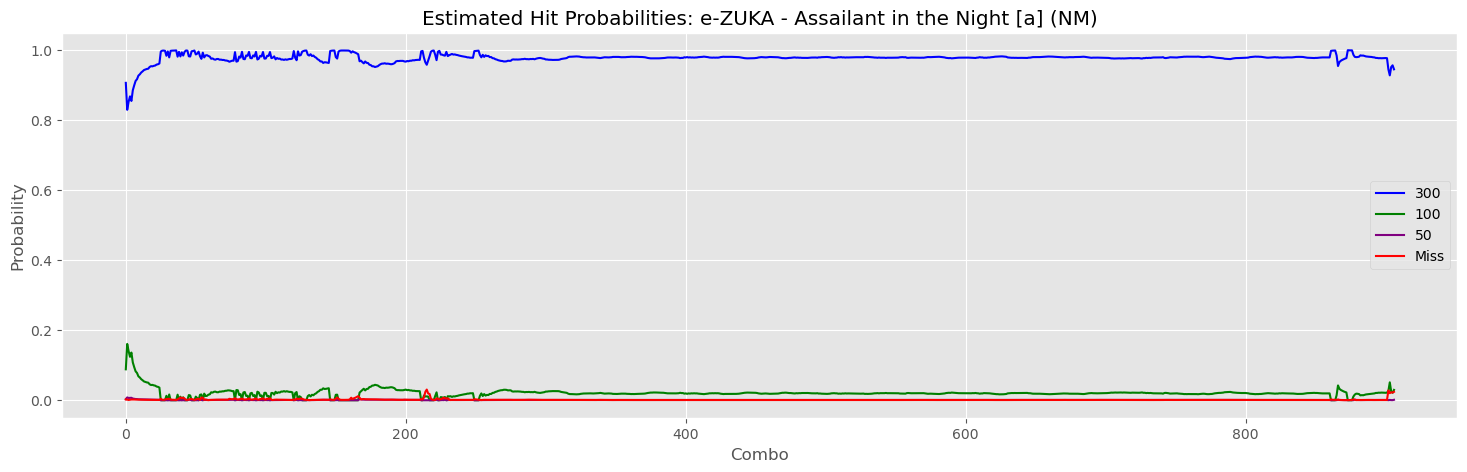

In [28]:
plot_difficulty_by_idx(541, beatmap_library, model)

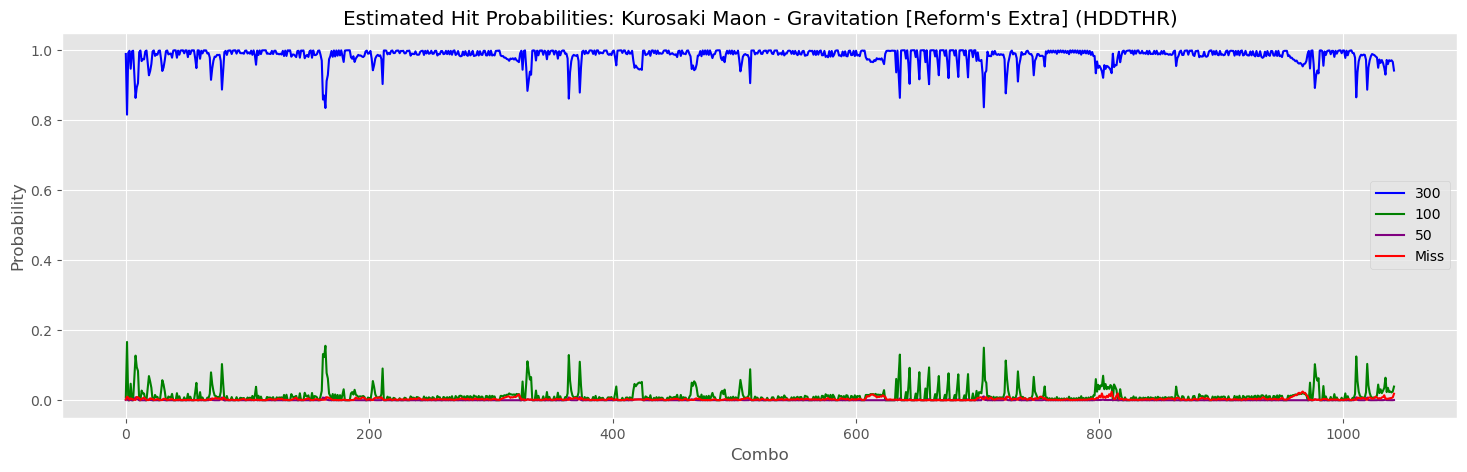

In [29]:
plot_difficulty_by_idx(346, beatmap_library, model)

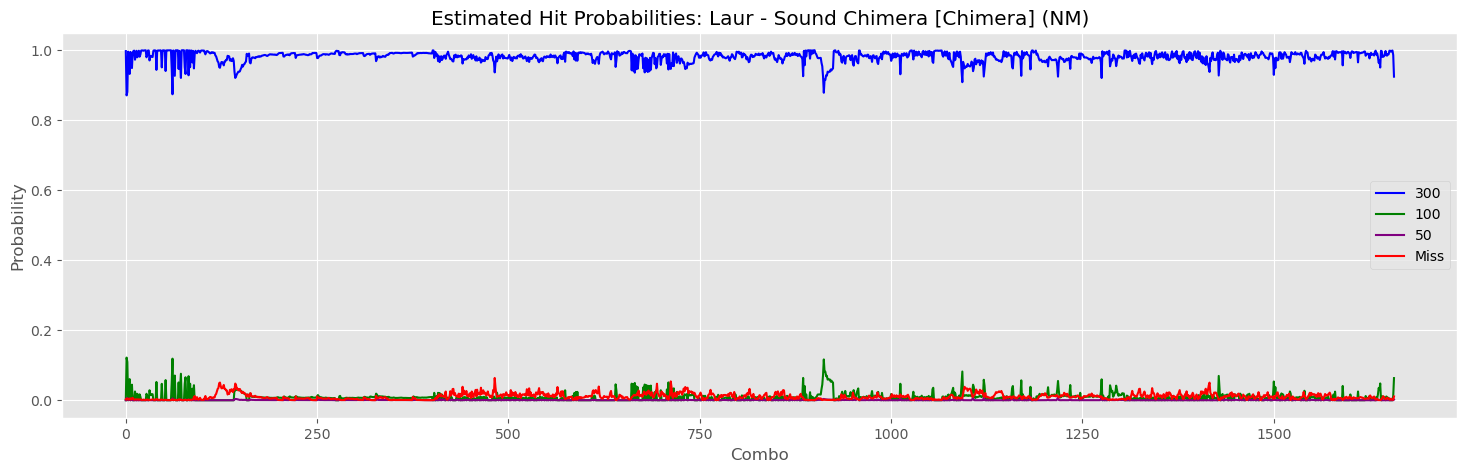

In [30]:
plot_difficulty_by_idx(796, beatmap_library, model)